In [1]:
#hide
# ! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [48]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import dtreeviz


pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
#| export
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
creds = ''

In [4]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)
     

In [5]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path('/home/petewin/.fastai/archive/bluebook-for-bulldozers')

In [6]:
#hide
Path.BASE_PATH = path

In [7]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

(#7) [Path('TrainAndValid.csv'),Path('Valid.csv'),Path('random_forest_benchmark_test.csv'),Path('Test.csv'),Path('median_benchmark.csv'),Path('ValidSolution.csv'),Path('Machine_Appendix.csv')]

In [8]:
for i in path.ls(file_type='text'):
    print(i)

/home/petewin/.fastai/archive/bluebook-for-bulldozers/TrainAndValid.csv
/home/petewin/.fastai/archive/bluebook-for-bulldozers/Valid.csv
/home/petewin/.fastai/archive/bluebook-for-bulldozers/random_forest_benchmark_test.csv
/home/petewin/.fastai/archive/bluebook-for-bulldozers/Test.csv
/home/petewin/.fastai/archive/bluebook-for-bulldozers/median_benchmark.csv
/home/petewin/.fastai/archive/bluebook-for-bulldozers/ValidSolution.csv
/home/petewin/.fastai/archive/bluebook-for-bulldozers/Machine_Appendix.csv


In [9]:
path.ls()

(#16) [Path('TrainAndValid.csv'),Path('Train.7z'),Path('Valid.csv'),Path('Data Dictionary.xlsx'),Path('Train.zip'),Path('bluebook-for-bulldozers.zip'),Path('to.pkl'),Path('random_forest_benchmark_test.csv'),Path('TrainAndValid.7z'),Path('Test.csv')...]

In [10]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

- SalesID: the uniue identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

In [11]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [12]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [13]:
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

In [14]:
df['ProductSize'] = df['ProductSize'].astype('category')

In [15]:
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

/tmp/ipykernel_992/3701344575.py:1: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


Kaggle tells us what metric to use: root mean squared log error (RMSLE) between the actual and predicted auction prices

In [16]:
dep_var = 'SalePrice'

In [17]:
df[dep_var].head()

0    66000.0
1    57000.0
2    10000.0
3    38500.0
4    11000.0
Name: SalePrice, dtype: float64

In [18]:
np_dep_var = df[dep_var].to_numpy()

In [19]:
df['ProductSize'].cat.codes

0        -1
1         2
2        -1
3         3
4        -1
         ..
412693    4
412694    4
412695    4
412696    4
412697    4
Length: 412698, dtype: int8

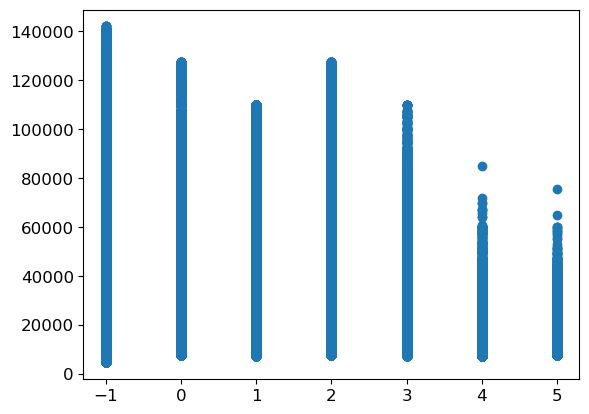

In [20]:
np_dep_var = df[dep_var].to_numpy()
np_ind_var = df['ProductSize'].cat.codes.to_numpy()
x = np_ind_var
y = np_dep_var
plt.scatter(x,y)
plt.show()

In [21]:
df[dep_var] = np.log(df[dep_var])

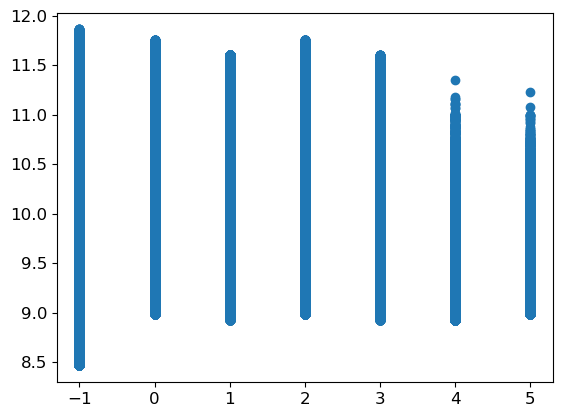

In [22]:
np_dep_var = df[dep_var].to_numpy()
np_ind_var = df['ProductSize'].cat.codes.to_numpy()
x = np_ind_var
y = np_dep_var
plt.scatter(x,y)
plt.show()

In [23]:
df['saledate'].head()

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
Name: saledate, dtype: object

In [24]:
df = add_datepart(df, 'saledate')

In [25]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [26]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [27]:
df_test.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

In [28]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

Using `TabularPandas` and `TabularProc` for cleaning

In [29]:
procs = [Categorify, FillMissing]

In [30]:
cond = (df.saleYear<2011) | ((df.saleMonth<10) & (df.saleYear==2011))

In [31]:
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [32]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [33]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [34]:
len(to.train), len(to.valid)

(393137, 19561)

In [35]:
len(to.train)/(len(to.train)+len(to.valid)), len(to.valid)/(len(to.train)+len(to.valid))

(0.9526021449098372, 0.04739785509016278)

In [36]:
to.show(5)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340
3,High,PC120-6E,PC120,#na#,-6E,#na#,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",Texas,TEX,Track Excavators,#na#,EROPS w AC,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139251,1026470,332,121,3.0,2001,3486.0,2011,5,20,19,3,139,1.305763e+09,10.558414
4,Medium,S175,S175,#na#,#na#,#na#,#na#,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,EROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139253,1057373,17311,121,3.0,2007,722.0,2009,7,30,23,3,204,1.248307e+09,9.305651


In [37]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [],y_names=dep_var, splits=splits)
to1.show(5)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340
3,Texas,TEX,#na#,EROPS w AC,10.558414
4,New York,SSL,#na#,EROPS,9.305651


In [38]:
to1.items.head()

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,...,False,False,False,1.163635e+09
1,1139248,10.950807,117657,77,...,False,False,False,1.080259e+09
2,1139249,9.210340,434808,7009,...,False,False,False,1.077754e+09
3,1139251,10.558414,1026470,332,...,False,False,False,1.305763e+09
4,1139253,9.305651,1057373,17311,...,False,False,False,1.248307e+09


In [39]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [40]:
save_pickle(path/'to.pkl', to)

In [41]:
path.ls()

(#16) [Path('TrainAndValid.csv'),Path('Train.7z'),Path('Valid.csv'),Path('Data Dictionary.xlsx'),Path('Train.zip'),Path('bluebook-for-bulldozers.zip'),Path('to.pkl'),Path('random_forest_benchmark_test.csv'),Path('TrainAndValid.7z'),Path('Test.csv')...]

In [42]:
to = load_pickle(path/'to.pkl')

In [43]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [44]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs,y);

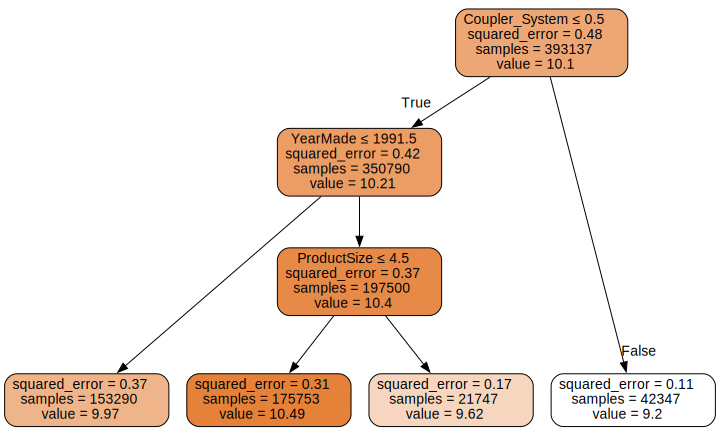

In [45]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2 )

In [49]:
samp_idx = np.random.permutation(len(y))[:500]

In [50]:
viz_model = dtreeviz.model(m, X_train=xs.iloc[samp_idx], y_train=y.iloc[samp_idx], target_name=dep_var)

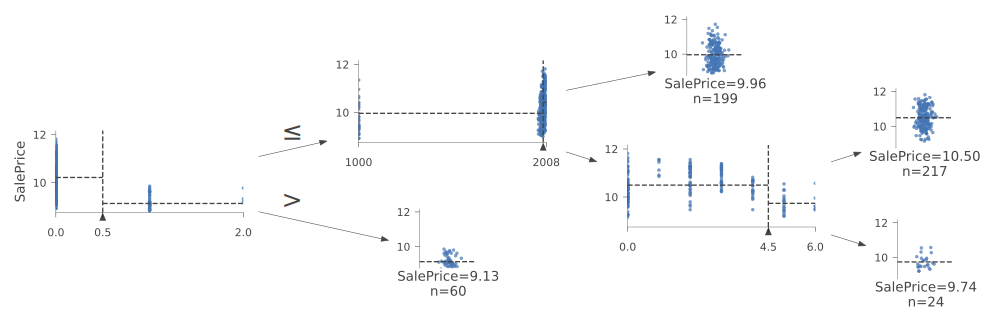

In [57]:
viz_model.view(fontname='DejaVu Sans', scale=1.8, label_fontsize=10, orientation='LR')